# Monitoring and analysis of model training: Sagemaker Profiler and Debugger

VGG16 image classification model is finetuned using a custom dataset containing 107 classes of images each one corresponding to a yoga pose. The model is submited and deployed in AWS Sagemaker. The code is written in Sagemaker Python SDK.

The Sagemaker ML framework used is PyTorch {`sagemaker.pytorch`}. The model definition and the training and inference code are passed in to PyTorch container via Sagemaker script mode.

Amazon Sagemaker Debugger API {`sagemaker.debugger`} is used to profile and debugg the training job in real time.

This notebook represents the *submission script* and contains code to download and preprocess the data as well as the setups to Sagemaker APIs to submit and evaluate the training job (i.e. the SageMaker debugger hook settings).

The *training scrip* is `train_model.py`, it contains the model definition and the training and validation code as well as code to perform model profiling and debugging.


## <a name="0">Notebook content:</a>
1. <a href="#1">Notebook setup</a>
2. <a href="#2">Dataset</a><br>
    2.1. <a href="#2.1">AWS S3 configuration</a><br>
    2.2. <a href="#2.2">Define S3 path to datasets and to manifest files</a><br>
    2.3. <a href="#2.3">Data Channels</a>
3. <a href="#3">Hyperparameters</a><br>
    3.1. <a href="#3.1">Grab the best hyperparameters from hyperparameter tunning job</a>
4. <a href="#4">Monitoring and analysis of model training: Sagemaker Profiler and Debugger</a><br>
    4.1. <a href="#4.1">Set-up debugging and profiling configuration (rules and hooks)</a><br>
    4.2. <a href="#4.2">Create and finetune a new model</a><br>
    4.3. <a href="#4.3">Plot debugger tensors</a><br>
    4.4. <a href="#4.4">Display profiler data (timeline chart and profiler report)</a>


## 1. <a name="1">Notebook setup</a>
(<a href="#0">Go to top</a>)

In [1]:
# Install smdebug
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 45.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.25.83 requires botocore==1.27.82, but you have botocore 1.27.89 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.27.89 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
# Import any packages that might be needed
# For instance Boto3 and Sagemaker and PyTorch ML framework 
import boto3
import sagemaker

from sagemaker import get_execution_role

from sagemaker.pytorch import PyTorch

from sagemaker.tuner import(
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

from sagemaker.debugger import(
    Rule,
    ProfilerRule,
    rule_configs,
    DebuggerHookConfig,
    ProfilerConfig,
    FrameworkProfile,
    CollectionConfig
)

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import requests
import shutil

import io
import pickle

## 2. <a name="2">Dataset</a>
(<a href="#0">Go to top</a>)

The dataset used is composed of a total of 5994 images of yoga poses. It is available on kaggle and can be downloaded via kaggle CLI from `franciscadossantos/rgb-only-yoga-pose-dataset`.
The dataset contains 107 classes of yoga poses, such as 'adho mukha svanasana', chakravakasana, savasana, etc. For the scope of this project it was divided into 3 subsets: train, test and validation. There are 3553 images in the training dataset, 1284 images in the test dataset and 1157 images in the validation dataset. 

**Support material:**

1. kaggle. [RGB-only Yoga Pose Dataset](https://www.kaggle.com/datasets/franciscadossantos/rgb-only-yoga-pose-dataset)


### 2.1. <a name="2.1">AWS S3 configuration</a>
(<a href="#0">Go to top</a>)

In [3]:
# grab sagemaker session and define s3 bucket name or use sagemaker.Session().default_bucket
# then, define file path prefix to send data to S3 bucket

sm_session = sagemaker.Session()
bucket = "capstone-project-sett22" ##"capstone-project-udc2022"  ##sm_session.default_bucket()

prefix = "yoga-data"

print(f"Bucket: {bucket}")
print(f"S3 path: {bucket}/{prefix}")

input_data = f"S3 path: {bucket}/{prefix}"

Bucket: capstone-project-sett22
S3 path: capstone-project-sett22/yoga-data


### 2.2. <a name="2.2">Define S3 path to datasets and to manifest files</a>
(<a href="#0">Go to top</a>)

In [4]:
## define the paths to data and metadata (s3 paths to datasets and .lst files)

input_data = f"s3://{bucket}/{prefix}"

train_lst_path = f"s3://{bucket}/{prefix}/train.lst"

test_lst_path = f"s3://{bucket}/{prefix}/test.lst"

valid_lst_path = f"s3://{bucket}/{prefix}/val.lst"


In [5]:
print('Bucket:\n {}'.format(bucket))

print('s3 path to data:\n {}'.format(input_data))

print('s3 path to train.lst:\n {}'.format(train_lst_path))

print('s3 path to test.lst:\n {}'.format(test_lst_path))

print('s3 path to valid.lst:\n {}'.format(valid_lst_path))

Bucket:
 capstone-project-sett22
s3 path to data:
 s3://capstone-project-sett22/yoga-data
s3 path to train.lst:
 s3://capstone-project-sett22/yoga-data/train.lst
s3 path to test.lst:
 s3://capstone-project-sett22/yoga-data/test.lst
s3 path to valid.lst:
 s3://capstone-project-sett22/yoga-data/val.lst


### 2.3. <a name="2.3">Data Channels</a>
(<a href="#0">Go to top</a>)


In [6]:
# model data channels

model_inputs = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data="s3://capstone-project-sett22/yoga-data/train/",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "test": sagemaker.inputs.TrainingInput(
        s3_data="s3://capstone-project-sett22/yoga-data/test/",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "valid": sagemaker.inputs.TrainingInput(
        s3_data="s3://capstone-project-sett22/yoga-data/val/",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "train_lst": sagemaker.inputs.TrainingInput(
        s3_data=train_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "test_lst": sagemaker.inputs.TrainingInput(
        s3_data=test_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "valid_lst": sagemaker.inputs.TrainingInput(
        s3_data=valid_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    )
}


## 3. <a name="3">Hyperparameters</a>
(<a href="#0">Go to top</a>)

### 3.1 <a name="3.1">Grab the best hyperparameters from hyperparameter tunning job</a>
(<a href="#0">Go to top</a>)

**Note**: refer to notebook [`hyperparameter_tuning.ipynb`](./hyperparameter_tuning.ipynb) for more details on hyperparameter tunning

In [3]:
# fetch name of best training job

sm_client = boto3.Session().client("sagemaker")

tuning_job_name = 'yoga-data-sec-warmst-221010-1656' #'yoga-data-221004-1441'

best_training_job = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName = tuning_job_name
)["BestTrainingJob"]

best_training_job['TunedHyperParameters']

{'batch_size': '"30"', 'lr': '0.12182095106235333'}

In [5]:
# Grab the best hyperparameters from hyperparameter tunning best_estimator (Notebook `hyperparameter_tuning.ipynb`)

print(f"epochs (default): {6}")
print(f"Test batch_size (static): {20}")
#print(f"Test batch_size: {best_training_job['TunedHyperParameters']['test_batch_size']}")
print(f"Best batch_size: {best_training_job['TunedHyperParameters']['batch_size']}")
print(f"Best lr: {best_training_job['TunedHyperParameters']['lr']}")

epochs (default): 6
Test batch_size (static): 20
Best batch_size: "30"
Best lr: 0.12182095106235333


In [6]:
epochs = '10'
test_batch_size = '20'
#test_batch_size = best_training_job['TunedHyperParameters']['test_batch_size']
#test_batch_size = ''.join(i for i in test_batch_size if i.isalnum())
batch_size = best_training_job['TunedHyperParameters']['batch_size']
batch_size = ''.join(i for i in batch_size if i.isalnum())
lr = best_training_job['TunedHyperParameters']['lr']
print(epochs, test_batch_size, batch_size, lr)
print(type(epochs), type(test_batch_size), type(batch_size), type(lr))

10 20 30 0.12182095106235333
<class 'str'> <class 'str'> <class 'str'> <class 'str'>


In [ ]:
"""
epochs = '10'
test_batch_size = '20'
batch_size = '30'
lr = '0.12182095106235333'
"""

## 4. <a name="4">Monitoring and analysis of model training: Sagemaker Profiler and Debugger</a>
(<a href="#0">Go to top</a>)

Create and finetune a new model using the best hyperparameters, found in Hyperparameter Tuning job step [`hyperparameter_tuning.ipynb`](./hyperparameter_tuning.ipynb).

**Support reading:**

1. Sagemaker Developer Guide: [Amazon SageMaker Debugger API Operations](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-apis.html)

2. Sagemaker Developer Guide: [Configure Debugger Using Amazon SageMaker Python SDK](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-configuration.html)

3. Sagemaker Read the Docs: [Sagemaker Debugger](https://sagemaker.readthedocs.io/en/stable/api/training/debugger.html#)

4. AWS Machine Learning Blog: [ML Explainability with Amazon SageMaker Debugger](https://aws.amazon.com/blogs/machine-learning/ml-explainability-with-amazon-sagemaker-debugger/)


### 4.1. <a name="4.1">Set-up debugging and profiling configuration (rules and hooks)</a>
(<a href="#0">Go to top</a>)

In [7]:
# grab default_bucket name
#bucket = sm_session.default_bucket()
print(f"Bucket:{bucket}")

Bucket:capstone-project-sett22


In [8]:
# configure debugger and profiler rules
rules = [
    ## debugger
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ## profiler
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]


In [9]:
# define tensor collections for SageMaker Debugger
collection_configs = [
    CollectionConfig(
        name = 'all',
        parameters={
            "include_regex": ".*",
            "train.save_interval": "100",
            "eval.save_interval": "10"
        }
    )
    
]

# define debugger (hook) configuration
hook_config = DebuggerHookConfig(
    s3_output_path = f"s3://{bucket}/Profiler-Debugger/debug-output",
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    },
    collection_configs = collection_configs
)


In [ ]:
##-----------------------------------------------------------------------

In [28]:
# OR, a short way to define debugger config, without defining collections
hook_config = DebuggerHookConfig(
    s3_output_path=f"s3://{bucket}/Profiler-Debugger/debug-output",
    hook_parameters={
        "train.save_interval":"100",
        "eval.save_interval":"10"
    }
)

In [ ]:
##-----------------------------------------------------------------------

In [10]:
# define the profiler configuration
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

### 4.2. <a name="4.2">Create and finetune a new model</a>
(<a href="#0">Go to top</a>)

In [11]:
# Create and fit an estimator with best hyperparameters values
# pass debugging and profiling rules and hooks to the estimator

epochs = '10'
test_batch_size = '20'
batch_size = '30'
lr = '0.12182095106235333'

hyperparameters = {
    'epochs': epochs,
    'batch_size': batch_size,
    'test_batch_size': test_batch_size,
    'lr': lr,
}

best_estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="capstone-project", #prefix for training job name
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.4xlarge", #"ml.p3.2xlarge", #"ml.p2.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
    rules=rules,
)


In [ ]:
%%time

best_estimator.fit(inputs=model_inputs, logs=True)

2022-10-12 07:06:21 Starting - Starting the training job...
2022-10-12 07:06:48 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-10-12 07:08:16 Downloading - Downloading input data.........
2022-10-12 07:09:49 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-12 07:09:46,015 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-12 07:09:46,017 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-12 07:09:46,025 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-12 07:09:46,034 sagemaker_pytorch_container.training INF

[2022-10-12 07:10:25.633 algo-1:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-1/train-0-stepstart-1665558597017653.0_train-0-forwardpassend-1665558625632496.0/python_stats.
[2022-10-12 07:10:25.895 algo-1:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-1/train-0-forwardpassend-1665558625636788.0_train-1-stepstart-1665558625894916.8/python_stats.
[2022-10-12 07:10:29.039 algo-1:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-1/train-1-stepstart-1665558625898721.8_train-1-forwardpassend-1665558629038672.2/python_stats.
[2022-10-12 07:10:29.213 algo-1:26 INFO python_profiler.py:182] Dumping cProfile stats to /opt/ml/output/profiler/framework/pytorch/cprofile/26-algo-1/train-1-forwardpassend-1665558629041257.5_train-2-stepstart-1665558629212674.5/python_stats.
VanishingGradient: Error

In [13]:
# get a full description of the training job
job_name = best_estimator.latest_training_job.name
client = best_estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName = job_name)

print(f"Training job name: {job_name}")
print(f"Description: {description}")

Training job name: capstone-project-2022-10-12-07-06-20-151
Description: {'TrainingJobName': 'capstone-project-2022-10-12-07-06-20-151', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:967161726274:training-job/capstone-project-2022-10-12-07-06-20-151', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-967161726274/capstone-project-2022-10-12-07-06-20-151/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '"30"', 'epochs': '"10"', 'lr': '"0.12182095106235333"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"capstone-project-2022-10-12-07-06-20-151"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-967161726274/capstone-project-2022-10-12-07-06-20-151/source/sourcedir.tar.gz"', 'test_batch_size': '"20"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-t

### 4.3. <a name="4.3">Plot debugger tensors</a>
(<a href="#0">Go to top</a>)

**Support reading:**

1. GitHub: [Tensor Analysis Using Amazon SageMaker Debugger](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/mnist_tensor_analysis/mnist_tensor_analysis.ipynb)

2. Sagemaker Developer Guide: [Visualize SageMaker Debugger Output Tensors](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-enable-tensorboard-summaries.html)

3. Sagemaker Developer Guide: [Best Practices for Amazon SageMaker Debugger](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-best-practices.html#debugger-best-practices-monitor-metrics)

In [14]:
# retrieve s3 location of debugger tensors
tensors_path = best_estimator.latest_job_debugger_artifacts_path()
print("S3 path to debugger tensors: ", tensors_path)


S3 path to debugger tensors:  s3://capstone-project-sett22/Profiler-Debugger/debug-output/capstone-project-2022-10-12-07-06-20-151/debug-output


In [15]:
# Create an smdebug Trial object to retrieve the saved tensors

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(tensors_path)

# Fetch tensor names and print their lengths
trial.tensor_names()

[2022-10-12 08:27:33.821 ip-172-16-15-187.ec2.internal:7533 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-10-12 08:27:34.082 ip-172-16-15-187.ec2.internal:7533 INFO s3_trial.py:42] Loading trial debug-output at path s3://capstone-project-sett22/Profiler-Debugger/debug-output/capstone-project-2022-10-12-07-06-20-151/debug-output
[2022-10-12 08:27:36.243 ip-172-16-15-187.ec2.internal:7533 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-10-12 08:27:37.268 ip-172-16-15-187.ec2.internal:7533 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_input_0',
 'CrossEntropyLoss_input_1',
 'CrossEntropyLoss_output_0',
 'VGG_classifier.0.bias',
 'VGG_classifier.0.weight',
 'VGG_classifier.3.bias',
 'VGG_classifier.3.weight',
 'VGG_classifier.6.0.bias',
 'VGG_classifier.6.0.weight',
 'VGG_features.0.bias',
 'VGG_features.0.weight',
 'VGG_features.10.bias',
 'VGG_features.10.weight',
 'VGG_features.12.bias',
 'VGG_features.12.weight',
 'VGG_features.14.bias',
 'VGG_features.14.weight',
 'VGG_features.17.bias',
 'VGG_features.17.weight',
 'VGG_features.19.bias',
 'VGG_features.19.weight',
 'VGG_features.2.bias',
 'VGG_features.2.weight',
 'VGG_features.21.bias',
 'VGG_features.21.weight',
 'VGG_features.24.bias',
 'VGG_features.24.weight',
 'VGG_features.26.bias',
 'VGG_features.26.weight',
 'VGG_features.28.bias',
 'VGG_features.28.weight',
 'VGG_features.5.bias',
 'VGG_features.5.weight',
 'VGG_features.7.bias',
 'VGG_features.7.weight',
 'VGG_input_0',
 'VGG_output_0',
 'avgpool_input_0',
 'avgpool_output_0',
 'cl

In [16]:
## testing accessing individual tensors with regex

## regex=".*gradient" to retrieve gradients
## options are (regex=".*input", regex=".*output", regex=".*gradient" and regex=".*weight")
## see https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/mnist_tensor_analysis/mnist_tensor_analysis.ipynb

test_tensor = trial.tensor_names(regex=".*output")[0]
test_tensor

'CrossEntropyLoss_output_0'

In [17]:
len(trial.tensor(test_tensor).steps(mode=ModeKeys.TRAIN))

14

In [18]:
len(trial.tensor(test_tensor).steps(mode=ModeKeys.EVAL))

7

In [19]:
# create functions to plot an output tensor

from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


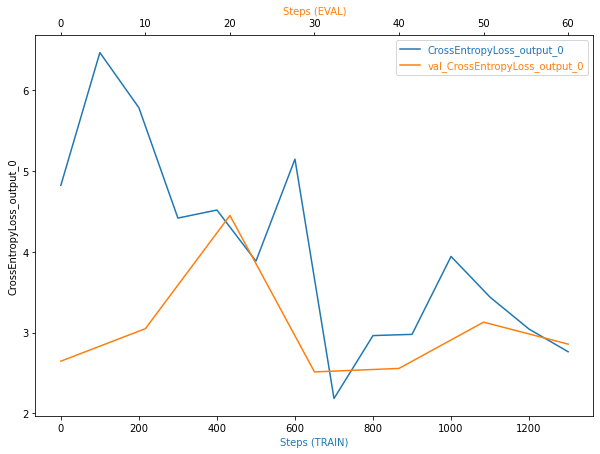

In [20]:
plot_tensor(trial, test_tensor)

### 4.4. <a name="4.4">Display profiler data (timeline chart and profiler report)</a>
(<a href="#0">Go to top</a>)

**Support reading:**

1. Sagemaker Developer Guide: [Plot the System Metrics and Framework Metrics Data](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-access-data-profiling-default-plot.html)

In [21]:
### use TrainingJob object to fetch system metrics saved to s3
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

region=sagemaker.Session().boto_region_name

tj = TrainingJob(job_name, region)

# check if profile data is available
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-967161726274/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-967161726274/capstone-project-2022-10-12-07-06-20-151/profiler-output


Profiler data from system is available


In [22]:
from smdebug.profiler.analysis.notebook_utils.heatmap import Heatmap

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()
framework_metrics_reader = tj.get_framework_metrics_reader()

view_heatmap = Heatmap(
    system_metrics_reader,
    framework_metrics_reader,
    select_dimensions=["CPU", "GPU", "I/O"],
    select_events=["total"],
    plot_height=450
)

[2022-10-12 08:29:24.831 ip-172-16-15-187.ec2.internal:7533 INFO metrics_reader_base.py:134] Getting 67 event files
select events:['total']
select dimensions:['CPU', 'GPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'I/OWaitPercentage', 'CPUUtilization'}


In [23]:
# Fetch the path to profiler output

rule_output_path = best_estimator.output_path + best_estimator.latest_training_job.job_name + "/rule-output"

print(f"You will find the profiler report in\n {rule_output_path}")

You will find the profiler report in
 s3://sagemaker-us-east-1-967161726274/capstone-project-2022-10-12-07-06-20-151/rule-output


In [24]:
# list s3 objects into the rule_output path
! aws s3 ls {rule_output_path} --recursive

2022-10-12 08:14:38     386801 capstone-project-2022-10-12-07-06-20-151/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-10-12 08:14:38     236809 capstone-project-2022-10-12-07-06-20-151/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-10-12 08:14:33        192 capstone-project-2022-10-12-07-06-20-151/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-10-12 08:14:33        200 capstone-project-2022-10-12-07-06-20-151/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-10-12 08:14:33       2219 capstone-project-2022-10-12-07-06-20-151/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-10-12 08:14:33        127 capstone-project-2022-10-12-07-06-20-151/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-10-12 08:14:33        199 capstone-project-2022-10-12-07-06-20-151/rule-output/ProfilerReport/profiler-output/profiler-re

In [25]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-967161726274/capstone-project-2022-10-12-07-06-20-151/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-967161726274/capstone-project-2022-10-12-07-06-20-151/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-967161726274/capstone-project-2022-10-12-07-06-20-151/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-967161726274/capstone-project-2022-10-12-07-06-20-151/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-ea

In [26]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in best_estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [27]:
print(profiler_report_name)

ProfilerReport


In [28]:
# display the SageMaker Debugger profiling report

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")